<a href="https://colab.research.google.com/github/9jam/w266-final-project/blob/main/load_saved_keras_model_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## MODEL PERFORMANCE ANALISYS AND ATTENTION MAP EXPLORATION



In [2]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 6.8 MB/s 
     |████████████████████████████████| 636 kB 55.2 MB/s 
     |████████████████████████████████| 895 kB 45.0 MB/s 
     |████████████████████████████████| 3.3 MB 50.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [22]:
import numpy as np
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow_datasets as tfds

import transformers

from transformers import BertTokenizer, TFBertModel, TFBertForPreTraining, TFBertForSequenceClassification
from tensorflow.keras import backend as K

import logging
tf.get_logger().setLevel(logging.ERROR)

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
model = tf.keras.models.load_model('/content/drive/MyDrive/w266_project/models/mbert-base-mclass-large300k_ds')

In [60]:
#mbert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

### Binary classification

In [ ]:
dataset = pd.read_pickle("/content/drive/MyDrive/meduza_bert_big_df.pkl")
dataset

,text,target,orig_word,new_word,case,shift_case,adj
4636,Даже в коллективном творчестве редко можно обо...,0,произведению,произведение,Dat,Nom,0
65395,Кто-то промолчал по ряда личных причин.,0,ряду,ряда,Dat,Gen,0
87153,Направлять трафику за пределы России будет зап...,0,трафик,трафику,Acc,Dat,0
159623,"К январю 2019 года в сети, задолжавшей кредито...",0,кредиторам,кредиторов,Dat,Acc,0
152020,У каждого фонда есть свой устав и положение о ...,0,программах,программ,Loc,Gen,0
...,...,...,...,...,...,...,...
25876,Главное туристическое развлечение — поездки на...,1,None,None,None,None,None
35014,На 11 поехала в БТИ подписывать договор с детя...,0,детьми,детям,Ins,Dat,0
173747,В 2017 год ситуация повторилась — и вице-премь...,0,году,год,Loc,Acc,0
106220,С 1 августу авиакомпания будет отчислять в спе...,0,августа,августу,Gen,Dat,0


In [ ]:
X_big_val = dataset['text'][280000:350000]
y_big_val = dataset['target'][280000:350000]

In [ ]:
num_train_examples = 280000
num_test_examples = 70000
num_tiny_set = 5

max_length = 128


x_test = tokenizer([str(x) for x in X_big_val[:num_test_examples]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = y_big_val[:num_test_examples]

In [ ]:
test_results = model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
                             batch_size=8, 
                             steps=8750)

In [ ]:
test_analysis_df = dataset[280000:350000].copy()
test_analysis_df['result'] = np.round(test_results,0).astype(int)

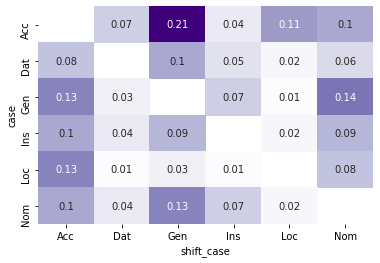

In [ ]:
sns.heatmap(pd.crosstab(test_analysis_df.case, test_analysis_df.shift_case, values=test_analysis_df.result, aggfunc='mean', margins=False).round(2), cmap='Purples', annot=True, cbar=False)

### Multiclass classification

In [14]:
cases = ['Nom', 'Acc', 'Ins', 'Dat', 'Gen', 'Loc']
case_shifts = [(case1, case2) for case1 in cases for case2 in cases if case1 != case2]
classes = {shift:i+1 for i,shift in enumerate(case_shifts)}
classes

{('Acc', 'Dat'): 8,
 ('Acc', 'Gen'): 9,
 ('Acc', 'Ins'): 7,
 ('Acc', 'Loc'): 10,
 ('Acc', 'Nom'): 6,
 ('Dat', 'Acc'): 17,
 ('Dat', 'Gen'): 19,
 ('Dat', 'Ins'): 18,
 ('Dat', 'Loc'): 20,
 ('Dat', 'Nom'): 16,
 ('Gen', 'Acc'): 22,
 ('Gen', 'Dat'): 24,
 ('Gen', 'Ins'): 23,
 ('Gen', 'Loc'): 25,
 ('Gen', 'Nom'): 21,
 ('Ins', 'Acc'): 12,
 ('Ins', 'Dat'): 13,
 ('Ins', 'Gen'): 14,
 ('Ins', 'Loc'): 15,
 ('Ins', 'Nom'): 11,
 ('Loc', 'Acc'): 27,
 ('Loc', 'Dat'): 29,
 ('Loc', 'Gen'): 30,
 ('Loc', 'Ins'): 28,
 ('Loc', 'Nom'): 26,
 ('Nom', 'Acc'): 1,
 ('Nom', 'Dat'): 3,
 ('Nom', 'Gen'): 4,
 ('Nom', 'Ins'): 2,
 ('Nom', 'Loc'): 5}

In [ ]:
mdataset = pd.read_pickle("/content/drive/MyDrive/meduza_mclass_large_ds.pkl")
mdataset

,text,target,orig_word,new_word,case,shift_case,adj
182599,За время экспедиций на МКС Уитсон восемь раз в...,0,None,None,None,None,None
123447,"Есть технологии лучше, но jpeg работает везде ...",1,история,историю,Nom,Acc,1
189102,Первый вариант неприемлем для Меркель и Макрон...,10,распад,распаде,Acc,Loc,0
160164,"Сама Хашеми рассказала родным, что в заключени...",0,None,None,None,None,None
120559,Рафаэль Надаль ранее выигрывал « Ролан Гаррос ...,28,годах,годами,Loc,Ins,0
...,...,...,...,...,...,...,...
194008,"Но и мы не умерли, вот уже четырнадцатого года...",9,год,года,Acc,Gen,1
220589,В принципу идея последовательной диверсификаци...,29,принципе,принципу,Loc,Dat,0
144287,Об этом со ссылке на неназванный источник сооб...,13,ссылкой,ссылке,Ins,Dat,0
33491,"— Конечно, это важно, но я бы призывал относит...",11,осторожностью,осторожность,Ins,Nom,1


#### EDA

In [ ]:
mdataset.groupby('target').count()

,text,orig_word,new_word,case,shift_case,adj
target,,,,,,
0,10000,0,0,0,0,0
1,10000,10000,10000,10000,10000,10000
2,10000,10000,10000,10000,10000,10000
3,10000,10000,10000,10000,10000,10000
4,10000,10000,10000,10000,10000,10000
5,10000,10000,10000,10000,10000,10000
6,10000,10000,10000,10000,10000,10000
7,10000,10000,10000,10000,10000,10000
8,10000,10000,10000,10000,10000,10000


#### Make datasets

In [ ]:
X_mclass_val = mdataset['text'][224000:280000]
y_mclass_val = mdataset['target'][224000:280000]

In [ ]:
num_train_examples = 224000
num_test_examples = 56000
num_tiny_set = 5

max_length = 128


x_test = tokenizer([str(x) for x in X_mclass_val[:num_test_examples]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = y_mclass_val[:num_test_examples]

In [ ]:
test_results = model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
                             batch_size=8, 
                             steps=7000)

In [ ]:
test_analysis_df = mdataset[224000:280000].copy()
test_analysis_df['result'] = list(pd.DataFrame(test_results).idxmax(axis=1))

In [ ]:
test_analysis_df

,text,target,orig_word,new_word,case,shift_case,adj,result
190265,"Прошу помочь в поиске », — говорится в объявле...",26,объявлении,объявление,Loc,Nom,0,26
208913,Украинское издание « Обозреватель » со ссылкой...,28,шпионаже,шпионажем,Loc,Ins,0,28
222837,"До этого, работая в национальный комитет Респу...",27,комитете,комитет,Loc,Acc,1,26
203190,Представляя в своем эфире группу « Пошлая Молл...,9,термин,термина,Acc,Gen,0,9
100334,В 15 годы он решил заняться рэпом.,21,лет,годы,Gen,Nom,0,22
...,...,...,...,...,...,...,...,...
229679,Как заметил 26 апреля в своем выступлении на а...,27,панели,панель,Loc,Acc,1,27
25872,"Наверное, опыт отношений и с едой, и с литерат...",13,литературой,литературе,Ins,Dat,0,13
115038,"Проблема в том, что самой церкви пока нет — он...",8,автокефалию,автокефалии,Acc,Dat,0,24
25745,В США фильму « Красавица и чудовище » присвоен...,25,сцен,сценах,Gen,Loc,0,25


In [ ]:
drive.flush_and_unmount()

In [ ]:
test_analysis_df.to_pickle("/content/drive/MyDrive/w266_project/results/mbert-base-mclass-large_ds/results_mclass_val_56k_df.pkl")

### Analysis of results

In [5]:
test_analysis_df = pd.read_pickle("/content/drive/MyDrive/w266_project/results/mbert-base-mclass-large_ds/results_mclass_val_56k_df.pkl")

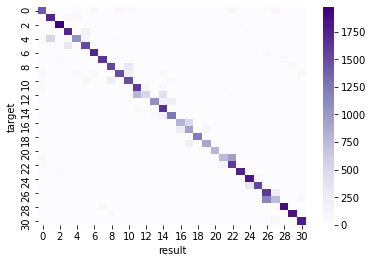

In [6]:
sns.heatmap(pd.crosstab(test_analysis_df.target, test_analysis_df.result), cmap="Purples", cbar=True)

In [7]:
sum(test_analysis_df.target == test_analysis_df.result)/len(test_analysis_df.target)

0.7780714285714285

In [9]:

print(classification_report(test_analysis_df.target, test_analysis_df.result)) #target_names=target_names))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2025
           1       0.72      0.89      0.80      1947
           2       0.92      0.96      0.94      2059
           3       0.76      0.86      0.81      1996
           4       0.82      0.57      0.67      1904
           5       0.76      0.77      0.77      1976
           6       0.90      0.90      0.90      1927
           7       0.93      0.90      0.92      1830
           8       0.79      0.75      0.77      2049
           9       0.87      0.73      0.80      2039
          10       0.70      0.76      0.73      1971
          11       0.61      0.85      0.71      1898
          12       0.78      0.28      0.42      1843
          13       0.87      0.68      0.76      1581
          14       0.63      0.88      0.73      1900
          15       0.78      0.79      0.78      1611
          16       0.67      0.58      0.62      1387
          17       0.55    

In [10]:
pd.crosstab(test_analysis_df.target, test_analysis_df.result, normalize='index')

result,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.711605,0.011852,0.004938,0.005926,0.015309,0.001975,0.029136,0.003457,0.005926,0.026173,0.022222,0.010864,0.005432,0.001975,0.011358,0.001481,0.006420,0.005432,0.002469,0.003951,0.000988,0.012840,0.038519,0.007901,0.002963,0.000000,0.013333,0.030617,0.000494,0.001481,0.002963
1,0.007191,0.893169,0.004109,0.024653,0.036980,0.005136,0.003082,0.000000,0.000514,0.000000,0.000514,0.001027,0.003082,0.000000,0.002054,0.000514,0.001027,0.005650,0.000514,0.000514,0.000000,0.002054,0.003082,0.000000,0.000000,0.000000,0.000514,0.002568,0.000000,0.000514,0.001541
2,0.006314,0.001943,0.957261,0.002428,0.001457,0.000486,0.000486,0.009228,0.000000,0.000000,0.000000,0.000486,0.000486,0.000000,0.000486,0.000000,0.000971,0.000000,0.003885,0.000000,0.000486,0.000486,0.000971,0.008256,0.000000,0.000000,0.000486,0.001457,0.001457,0.000000,0.000486
3,0.005511,0.004008,0.002505,0.859719,0.007014,0.090681,0.000501,0.000501,0.006513,0.001002,0.002004,0.000501,0.000000,0.003507,0.000501,0.001002,0.001002,0.000501,0.000000,0.000000,0.000501,0.000501,0.000000,0.000000,0.008517,0.001503,0.000000,0.000000,0.000000,0.001503,0.000501
4,0.020483,0.278887,0.003676,0.023109,0.566176,0.066702,0.002101,0.000000,0.000000,0.008403,0.001050,0.003676,0.000000,0.001050,0.011555,0.000000,0.000525,0.003151,0.000000,0.002101,0.000000,0.001576,0.000525,0.001050,0.000000,0.000000,0.001050,0.001576,0.000000,0.000000,0.001576
5,0.003543,0.008097,0.002024,0.170547,0.004555,0.773785,0.000506,0.000000,0.003036,0.000506,0.005061,0.000506,0.000000,0.000000,0.001012,0.007591,0.000000,0.000506,0.000000,0.000506,0.007085,0.000000,0.000506,0.000506,0.001518,0.008603,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.010898,0.004670,0.000519,0.001557,0.002076,0.000519,0.902439,0.001557,0.000519,0.007265,0.001557,0.008303,0.001038,0.000519,0.002076,0.000000,0.009860,0.000000,0.000000,0.000000,0.001038,0.005708,0.000519,0.001038,0.000000,0.000000,0.030618,0.003114,0.000000,0.001038,0.001557
7,0.003279,0.001639,0.018033,0.000546,0.001639,0.001093,0.004372,0.901639,0.003825,0.002732,0.002732,0.003825,0.000546,0.001093,0.003825,0.000546,0.000546,0.000546,0.001639,0.000000,0.000000,0.000000,0.001093,0.009290,0.001093,0.000000,0.001639,0.001639,0.030055,0.000546,0.000546
8,0.010249,0.000488,0.000488,0.012689,0.000976,0.000488,0.001464,0.002928,0.751586,0.011713,0.155198,0.001952,0.000488,0.009273,0.000976,0.004392,0.000000,0.000488,0.000488,0.000488,0.000000,0.000488,0.000488,0.000000,0.006833,0.000000,0.001464,0.002440,0.000000,0.020986,0.000488


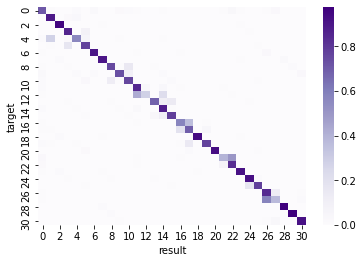

In [11]:
ax = sns.heatmap(pd.crosstab(test_analysis_df.target, test_analysis_df.result, normalize='index'), cmap="Purples", cbar=True)

In [ ]:
list(classes.keys())[list(classes.values()).index(1)]

('Nom', 'Acc')

In [12]:
def adjust_pred(df, class_dict):
  case_preds = []
  for row in df.iloc:
    if row.result == 0:
      case_pred = None
    else:
      case_pred = list(class_dict.keys())[list(class_dict.values()).index(row.result)][0]
    case_preds.append(case_pred)
  return case_preds

In [15]:
test_analysis_df['predict_case'] = adjust_pred(test_analysis_df, classes)
test_analysis_df

,text,target,orig_word,new_word,case,shift_case,adj,result,predict_case
190265,"Прошу помочь в поиске », — говорится в объявле...",26,объявлении,объявление,Loc,Nom,0,26,Loc
208913,Украинское издание « Обозреватель » со ссылкой...,28,шпионаже,шпионажем,Loc,Ins,0,28,Loc
222837,"До этого, работая в национальный комитет Респу...",27,комитете,комитет,Loc,Acc,1,26,Loc
203190,Представляя в своем эфире группу « Пошлая Молл...,9,термин,термина,Acc,Gen,0,9,Acc
100334,В 15 годы он решил заняться рэпом.,21,лет,годы,Gen,Nom,0,22,Gen
...,...,...,...,...,...,...,...,...,...
229679,Как заметил 26 апреля в своем выступлении на а...,27,панели,панель,Loc,Acc,1,27,Loc
25872,"Наверное, опыт отношений и с едой, и с литерат...",13,литературой,литературе,Ins,Dat,0,13,Ins
115038,"Проблема в том, что самой церкви пока нет — он...",8,автокефалию,автокефалии,Acc,Dat,0,24,Gen
25745,В США фильму « Красавица и чудовище » присвоен...,25,сцен,сценах,Gen,Loc,0,25,Gen


In [20]:
true_pos = test_analysis_df[test_analysis_df.target*test_analysis_df.result != 0]
false_pos = test_analysis_df.loc[((test_analysis_df['target'] == 0) & (test_analysis_df['result'] != 0))]
true_neg = test_analysis_df.loc[((test_analysis_df['target'] == 0) & (test_analysis_df['result'] == 0))]
false_neg = test_analysis_df.loc[((test_analysis_df['target'] != 0) & (test_analysis_df['result'] == 0))]

precision = len(true_pos)/(len(true_pos)+len(false_pos))
recall = len(true_pos)/(len(true_pos)+len(false_neg))
f = lambda b: (1+b**2)*precision*recall/(b**2*precision + recall)

print(f"True positive: {len(true_pos)}\nFalse positive: {len(false_pos)}\nTrue negative: {len(true_neg)}\nFalse negative: {len(false_neg)}\n")
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f(1)}\nF0.5: {f(0.5)}")

True positive: 53426
False positive: 584
True negative: 1441
False negative: 549

Precision: 0.9891871875578596
Recall: 0.9898286243631311
F1: 0.9895078020095383
F0.5: 0.989315408403237


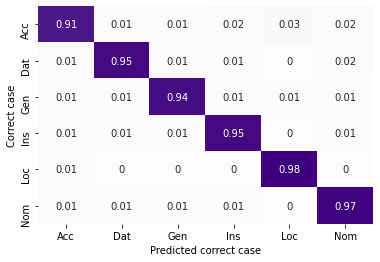

In [23]:
ax = sns.heatmap(pd.crosstab(true_pos.case, true_pos.predict_case, margins=False, normalize='index').round(2), cmap='Purples', annot=True, cbar=False)
ax.set(xlabel='Predicted correct case', ylabel='Correct case')
plt.show()

In [ ]:
len(test_analysis_df[test_analysis_df.case == test_analysis_df.predict_case])/len(test_analysis_df)

0.9074642857142857

In [17]:
test_analysis_df2 = test_analysis_df.copy()

In [18]:
test_analysis_df2.loc[test_analysis_df2.case.isna(), 'case'] = 'OK'
test_analysis_df2.loc[test_analysis_df2.predict_case.isna(), 'predict_case'] = 'OK'

In [19]:
print(classification_report(test_analysis_df2.case, test_analysis_df2.predict_case))

              precision    recall  f1-score   support

         Acc       0.93      0.90      0.92      9816
         Dat       0.95      0.94      0.95      6042
         Gen       0.95      0.93      0.94      9709
         Ins       0.94      0.94      0.94      8833
         Loc       0.95      0.98      0.96      9693
         Nom       0.93      0.96      0.95      9882
          OK       0.72      0.71      0.72      2025

    accuracy                           0.93     56000
   macro avg       0.91      0.91      0.91     56000
weighted avg       0.93      0.93      0.93     56000



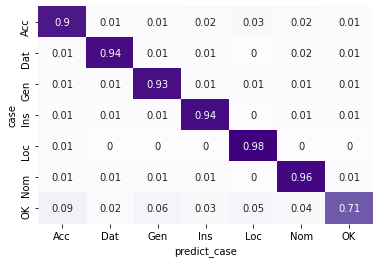

In [ ]:
sns.heatmap(pd.crosstab(test_analysis_df2.case, test_analysis_df2.predict_case, margins=False, normalize='index').round(2), cmap='Purples', annot=True, cbar=False)

In [ ]:
true_pos['predict_case'] = true_pos.result.apply(lambda x: list(classes.keys())[list(classes.values()).index(x)][0])
true_pos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,target,orig_word,new_word,case,shift_case,adj,result,predict_case
190265,"Прошу помочь в поиске », — говорится в объявле...",26,объявлении,объявление,Loc,Nom,0,26,Loc
208913,Украинское издание « Обозреватель » со ссылкой...,28,шпионаже,шпионажем,Loc,Ins,0,28,Loc
222837,"До этого, работая в национальный комитет Респу...",27,комитете,комитет,Loc,Acc,1,26,Loc
203190,Представляя в своем эфире группу « Пошлая Молл...,9,термин,термина,Acc,Gen,0,9,Acc
100334,В 15 годы он решил заняться рэпом.,21,лет,годы,Gen,Nom,0,22,Gen
...,...,...,...,...,...,...,...,...,...
229679,Как заметил 26 апреля в своем выступлении на а...,27,панели,панель,Loc,Acc,1,27,Loc
25872,"Наверное, опыт отношений и с едой, и с литерат...",13,литературой,литературе,Ins,Dat,0,13,Ins
115038,"Проблема в том, что самой церкви пока нет — он...",8,автокефалию,автокефалии,Acc,Dat,0,24,Gen
25745,В США фильму « Красавица и чудовище » присвоен...,25,сцен,сценах,Gen,Loc,0,25,Gen


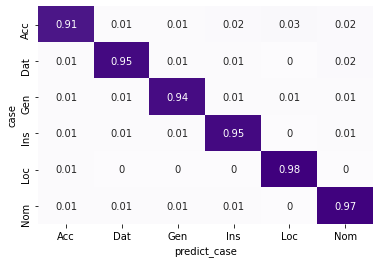

In [ ]:
sns.heatmap(pd.crosstab(true_wrong.case, true_wrong.predict_case, margins=False, normalize='index').round(2), cmap='Purples', annot=True, cbar=False)

In [ ]:
1-len(true_wrong[true_wrong.case != true_wrong.predict_case]) / len(true_wrong)

0.9511848163815371

In [ ]:
len(test_analysis_df[test_analysis_df.target==test_analysis_df.result])/len(test_analysis_df)

0.7780714285714285

In [25]:
def show_self_attn_trim(sentence, model, tokenizer, layer=None):
  tokens = [tokenizer.cls_token] + tokenizer.tokenize(sentence) + [tokenizer.sep_token]
  token_tensor = tokenizer(sentence, return_tensors='tf')
  model_out = model(token_tensor,output_attentions=True)
  attention = model_out[-1]
  attn_np = np.array(tf.squeeze(np.array(attention),1))
  attn_layers = np.mean(attn_np, axis=1)
  attn_whole = np.mean(attn_layers, axis=0)
  if layer:
    attn_layer_df = pd.DataFrame(attn_layers[layer], index = tokens, columns = tokens)

    print(f'Average attention across all heads for layer: {layer}')
    sns.heatmap(attn_layer_df.iloc[1:-1, 1:11], cmap='Purples', cbar=False)
  else:
    attn_df = pd.DataFrame(attn_whole, index = tokens, columns = tokens)

    print(f'Average attention across all layers: {layer}')
    sns.heatmap(attn_df.iloc[1:-1, 1:11], cmap='Purples', cbar=False)

In [434]:
def show_self_attn(sentence, model, tokenizer, layer=None, head=None):
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  tokens = [tokenizer.cls_token] + tokenizer.tokenize(sentence) + [tokenizer.sep_token]
  token_tensor = tokenizer(sentence, return_tensors='tf')
  model_out = model(token_tensor,output_attentions=True)
  attention = model_out[-1]
  attn_np = np.array(tf.squeeze(np.array(attention),1))
  attn_layers = np.mean(attn_np, axis=1)
  attn_whole = np.mean(attn_layers, axis=0)
  if head:
    attn_head_df = pd.DataFrame(attn_np[head[1]][head[0]], index = tokens, columns = tokens)
    print(f'Attention for head {head[0]}, layer {head[1]}')
    sns.heatmap(attn_head_df.iloc[:, 1:11], cmap='Purples', cbar=False)

  elif layer:
    attn_layer_df = pd.DataFrame(attn_layers[layer], index = tokens, columns = tokens)

    print(f'Average attention across all heads for layer: {layer}')
    sns.heatmap(attn_layer_df.iloc[:, 1:], cmap='Purples', cbar=False)
  else:
    attn_df = pd.DataFrame(attn_whole, index = tokens, columns = tokens)

    print('Average attention across all layers')
    sns.heatmap(attn_df.iloc[:, :], cmap='Purples', cbar=False)

In [69]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [70]:
sentence1 = 'The chicken crossed the road because it was hungry.'
sentence2 = 'The chicken crossed the road because it was narrow.'

Attention for head 1, layer 8


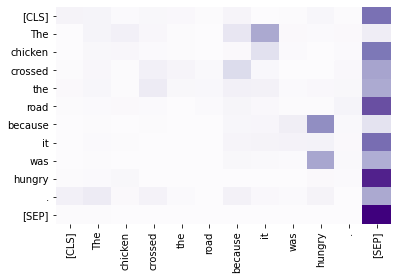

In [71]:
show_self_attn(sentence1, bert_model, tokenizer, layer=None, head=(1,8))

In [72]:
mbert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
tokenizer_ru = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [389]:
s = 20
print(true_pos.iloc[s])
sentence_ru = true_pos.text.iloc[s]
sentence_ru

text            Законопроект об обеспечением суверенитета над ...
target                                                         28
orig_word                                             обеспечении
new_word                                             обеспечением
case                                                          Loc
shift_case                                                    Ins
adj                                                             0
result                                                         28
predict_case                                                  Loc
Name: 226104, dtype: object


'Законопроект об обеспечением суверенитета над отдельными районами Донецкой и Луганской областей был внесен в Верховную Раду Украины в начале октября.'

In [431]:
sentence_ru2 = 'Законопроект об обеспечении суверенитета над отдельными районами Донецкой и Луганской областей был внесен в Верховную Раду Украины в начале октября.'

Attention for head 6, layer 3


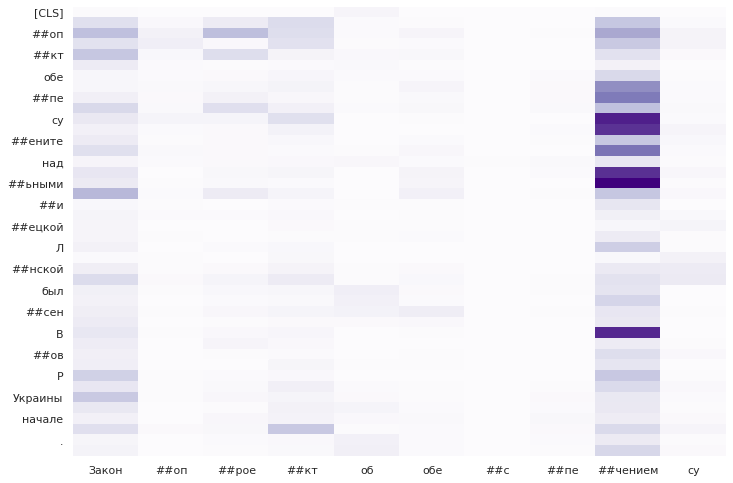

In [435]:
h=6
l=3
show_self_attn(sentence_ru, mbert_model, tokenizer_ru, layer=l, head=(h,l))

Attention for head 6, layer 3


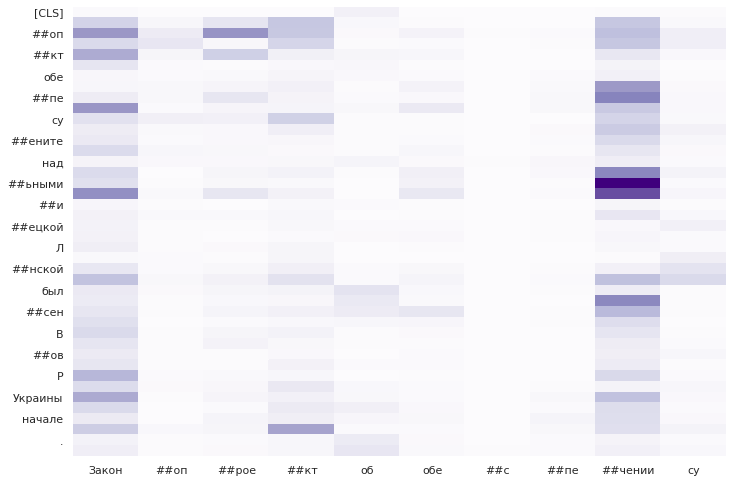

In [436]:
show_self_attn(sentence_ru2, mbert_model, tokenizer_ru, layer=l, head=(h,l))